In [1]:
import pandas as pd, numpy as np
from db_queries import get_ids, get_outputs, get_location_metadata, get_covariate_estimates
from get_draws.api import get_draws
import scipy.stats
from operator import attrgetter
from math import sqrt, pi
import matplotlib.pyplot as plt

## This notebook is a preliminary exploration of the hemoglobin distribution for women of reproductive age

The goal of this notebook is to:

1) Load hemoglobin distribution parameters using get_draws

2) Disaggregate mean hemoglobin by pregnancy status using adjustment factor

3) Estimate severity-specific anemia prevalence using hemoglobin distribution and age-and-pregnancy speicfic anemia thresholds

4) Compare estimates from #3 to anemia impairment estimates

**For now, all calculations are performed at the mean level without uncertainty for the sake of simplicity**

In [2]:
# define location and age group IDs of interest

locs = [165, 161, 214, 182] # pakistan, bangladesh, nigeria, malawi
ages = list(range(7,16))
# reminder, always want sex_id=2 (female)

# 1. Load hemoglobin distribution parameters

In [3]:
# mean hemoglobin concentration
mean = get_draws('modelable_entity_id',
                10487,
                source='epi',
                location_id=locs,
                age_group_id=ages,
                sex_id=2,
                year_id=2019,
                gbd_round_id=6,
                decomp_step='step4',
                status='best')
mean.head()

,age_group_id,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,draw_105,...,draw_997,draw_998,draw_999,location_id,measure_id,metric_id,modelable_entity_id,sex_id,year_id,model_version_id
0,7,131.576669,130.006851,126.753823,128.018065,133.273591,131.115555,130.538169,127.788556,127.888119,...,131.693836,129.286983,129.131233,161,19,3,10487,2,2019,474044
1,8,118.922773,126.221582,123.354380,126.262134,124.932018,122.562494,124.733401,123.766130,126.417171,...,123.436502,123.562551,128.478574,161,19,3,10487,2,2019,474044
2,9,119.445416,119.744885,123.663548,124.283216,118.579743,124.817976,123.868556,121.465009,121.658608,...,120.869506,120.472913,125.833589,161,19,3,10487,2,2019,474044
3,10,125.283728,125.009121,119.397039,122.817539,123.870315,121.480207,122.020435,124.570332,124.744182,...,125.456108,120.019112,122.695076,161,19,3,10487,2,2019,474044
4,11,125.122521,121.147369,124.487696,128.703954,127.822311,125.583439,122.830292,124.109611,122.808416,...,126.128345,122.630509,120.700463,161,19,3,10487,2,2019,474044


In [4]:
# hemoglobin distribution standard deviation
sd = get_draws('modelable_entity_id',
                10488,
                source='epi',
                location_id=locs,
                age_group_id=ages,
                sex_id=2,
                year_id=2019,
                gbd_round_id=6,
                decomp_step='step4',
                status='best')
sd.head()

,age_group_id,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,draw_105,...,draw_997,draw_998,draw_999,location_id,measure_id,metric_id,modelable_entity_id,sex_id,year_id,model_version_id
0,7,13.275545,10.520743,12.478364,11.074315,10.319840,9.552074,11.482975,12.820968,11.568589,...,11.489875,12.298117,9.942485,161,19,3,10488,2,2019,474047
1,8,13.539543,11.400473,10.763228,14.080062,11.942807,11.324351,11.840090,12.247414,13.130775,...,12.780025,12.573772,12.782688,161,19,3,10488,2,2019,474047
2,9,13.528640,13.927886,14.721699,15.840077,11.072700,15.942453,12.677813,15.067630,13.357706,...,13.921116,12.567939,13.100151,161,19,3,10488,2,2019,474047
3,10,13.207735,13.479330,11.098589,12.029322,11.833765,13.670128,13.568723,12.334150,11.460925,...,13.722549,13.112078,11.246742,161,19,3,10488,2,2019,474047
4,11,14.281189,15.560005,13.597733,12.801608,13.592397,11.282292,17.420670,15.393633,13.681489,...,14.033802,13.578819,15.315098,161,19,3,10488,2,2019,474047


# 2. Perform pregnancy disaggregation

In [5]:
# get age-specific fertility rate
asfr = get_covariate_estimates(13, 
                               location_id=locs,
                               age_group_id=ages,
                               sex_id=2,
                               year_id=2019,
                               gbd_round_id=6,
                               decomp_step='step4')

# get still birth to live birht ratio (not age-specific)
still = get_covariate_estimates(2267, 
                                location_id=locs,
                                year_id=2019,
                                gbd_round_id=6,
                                decomp_step='step4')

In [6]:
# calculate pregnancy rate
# NOTE: this is just used as the mean value for all draws in GBD methods
# we will do the same (just use means, no uncertainty)

# age-spec-preg-prev = (ASFR + stillbirth) * 46/52
# but still-birth covariate is measured in still births per live birth,
# so...

    # age-spec-preg-prev = (ASFR + (sbr_mean * ASFR)) * 46/52
    
asfr_prepped = asfr.set_index(['location_id','age_group_id'])
asfr_prepped = asfr_prepped[['mean_value']]
sbr = still.set_index(['location_id'])
sbr = sbr[['mean_value']]

p_preg = (asfr_prepped + (sbr * asfr_prepped)) * 46/52
p_preg.head()

mean_value
location_id age_group_id            
161         7               0.000682
            8               0.052362
            9               0.105422
            10              0.090039
            11              0.048537

In [7]:
# population mean hemoglobin
hb_pop = mean.set_index(['location_id','age_group_id'])
hb_pop = hb_pop.drop(columns=[c for c in hb_pop.columns if 'draw' not in c])
hb_pop.head()

draw_0      draw_1     draw_10    draw_100  \
location_id age_group_id                                                   
161         7             131.576669  130.006851  126.753823  128.018065   
            8             118.922773  126.221582  123.354380  126.262134   
            9             119.445416  119.744885  123.663548  124.283216   
            10            125.283728  125.009121  119.397039  122.817539   
            11            125.122521  121.147369  124.487696  128.703954   

                            draw_101    draw_102    draw_103    draw_104  \
location_id age_group_id                                                   
161         7             133.273591  131.115555  130.538169  127.788556   
            8             124.932018  122.562494  124.733401  123.766130   
            9             118.579743  124.817976  123.868556  121.465009   
            10            123.870315  121.480207  122.020435  124.570332   
            11            127.822311  125.583439  122.830292  124.109611   

                            draw_105    draw_106  ...    draw_990    draw_991  \
location_id age_group_id                          ...                           
161         7             127.888119  134.269665  ...  132.629892  127.563386   
            8             126.417171  128.350657  ...  128.983925  125.823625   
            9             121.658608  119.139191  ...  127.191962  121.699027   
            10            124.744182  119.359498  ...  121.166555  119.789437   
            11            122.808416  123.786324  ...  114.836797  125.800045   

                            draw_992    draw_993    draw_994    draw_995  \
location_id age_group_id                                                   
161         7             131.561974  128.479080  130.254982  130.120093   
            8             128.289240  130.669737  119.897130  127.467974   
            9             120.712246  121.153322  121.370690  125.672017   
            10            125.065134  124.389494  121.221193  121.139373   
            11            115.827505  125.078032  120.858680  124.079560   

                            draw_996    draw_997    draw_998    draw_999  
location_id age_group_id                                                  
161         7             132.948881  131.693836  129.286983  129.131233  
            8             124.626547  123.436502  123.562551  128.478574  
            9             124.850055  120.869506  120.472913  125.833589  
            10            124.053072  125.456108  120.019112  122.695076  
            11            127.209902  126.128345  122.630509  120.700463  

[5 rows x 1000 columns]

In [8]:
# calculate mean hemoglobin among pregnant women

# eq. 1: HB_preg / HB_non_preg = 0.92
# eq. 2: HB_pop = p_preg * HB_preg + (1 - p_preg) * HB_non_preg

    # so...
    
hb_preg = hb_pop / (p_preg.values + (1 - p_preg.values) / 0.92)
hb_preg.head()

draw_0      draw_1     draw_10    draw_100  \
location_id age_group_id                                                   
161         7             121.057141  119.612830  116.619881  117.783047   
            8             109.869191  116.612342  113.963420  116.649807   
            9             110.824451  111.102306  114.738139  115.313083   
            10            116.097297  115.842826  110.642250  113.811941   
            11            115.561438  111.890042  114.975122  118.869200   

                            draw_101    draw_102    draw_103    draw_104  \
location_id age_group_id                                                   
161         7             122.618395  120.632893  120.101669  117.571887   
            8             115.420953  113.231821  115.237456  114.343824   
            9             110.021257  115.809246  114.928351  112.698280   
            10            114.787523  112.572669  113.073285  115.436211   
            11            118.054926  115.987135  113.444367  114.625928   

                            draw_105    draw_106  ...    draw_990    draw_991  \
location_id age_group_id                          ...                           
161         7             117.663490  123.534832  ...  122.026159  117.364720   
            8             116.793041  118.579331  ...  119.164388  116.244682   
            9             112.877906  110.540327  ...  118.011890  112.915407   
            10            115.597314  110.607462  ...  112.282016  111.005875   
            11            113.424162  114.327344  ...  106.061685  116.187189   

                            draw_992    draw_993    draw_994    draw_995  \
location_id age_group_id                                                   
161         7             121.043621  118.207204  119.841122  119.717018   
            8             118.522590  120.721860  110.769371  117.763847   
            9             111.999847  112.409089  112.610768  116.601647   
            10            115.894731  115.268633  112.332647  112.256827   
            11            106.976689  115.520348  111.623412  114.598173   

                            draw_996    draw_997    draw_998    draw_999  
location_id age_group_id                                                  
161         7             122.319645  121.164941  118.950515  118.807218  
            8             115.138737  114.039290  114.155743  118.697510  
            9             115.839010  112.145757  111.777788  116.751558  
            10            114.956879  116.257038  111.218709  113.698458  
            11            117.489313  116.490402  113.259850  111.477285  

[5 rows x 1000 columns]

In [9]:
# and...
hb_non_preg = hb_preg / 0.92
hb_non_preg.head()

draw_0      draw_1     draw_10    draw_100  \
location_id age_group_id                                                   
161         7             131.583849  130.013945  126.760740  128.025051   
            8             119.423033  126.752546  123.873282  126.793268   
            9             120.461360  120.763376  124.715369  125.340307   
            10            126.192714  125.916115  120.263315  123.708632   
            11            125.610258  121.619611  124.972958  129.205652   

                            draw_101    draw_102    draw_103    draw_104  \
location_id age_group_id                                                   
161         7             133.280864  131.122710  130.545293  127.795529   
            8             125.457557  123.078066  125.258104  124.286765   
            9             119.588323  125.879616  124.922121  122.498130   
            10            124.769047  122.361597  122.905745  125.474142   
            11            128.320572  126.072973  123.309094  124.593400   

                            draw_105    draw_106  ...    draw_990    draw_991  \
location_id age_group_id                          ...                           
161         7             127.895098  134.276992  ...  132.637130  127.570348   
            8             126.948958  128.890577  ...  129.526509  126.352915   
            9             122.693376  120.152530  ...  128.273794  122.734138   
            10            125.649254  120.225502  ...  122.045669  120.658560   
            11            123.287133  124.268852  ...  115.284440  126.290423   

                            draw_992    draw_993    draw_994    draw_995  \
location_id age_group_id                                                   
161         7             131.569154  128.486091  130.262090  130.127193   
            8             128.828902  131.219413  120.401490  128.004181   
            9             121.738964  122.183792  122.403009  126.740921   
            10            125.972534  125.291992  122.100703  122.018291   
            11            116.279010  125.565596  121.329796  124.563232   

                            draw_996    draw_997    draw_998    draw_999  
location_id age_group_id                                                  
161         7             132.956136  131.701022  129.294038  129.138280  
            8             125.150801  123.955750  124.082329  129.019032  
            9             125.911967  121.897562  121.497596  126.903867  
            10            124.953129  126.366345  120.889901  123.585280  
            11            127.705776  126.620002  123.108532  121.170962  

[5 rows x 1000 columns]

In [10]:
# assume same SD 

hb_sd = sd.set_index(['location_id','age_group_id'])
hb_sd = hb_sd.drop(columns=[c for c in hb_sd.columns if 'draw' not in c])
hb_sd.head()

draw_0     draw_1    draw_10   draw_100  \
location_id age_group_id                                               
161         7             13.275545  10.520743  12.478364  11.074315   
            8             13.539543  11.400473  10.763228  14.080062   
            9             13.528640  13.927886  14.721699  15.840077   
            10            13.207735  13.479330  11.098589  12.029322   
            11            14.281189  15.560005  13.597733  12.801608   

                           draw_101   draw_102   draw_103   draw_104  \
location_id age_group_id                                               
161         7             10.319840   9.552074  11.482975  12.820968   
            8             11.942807  11.324351  11.840090  12.247414   
            9             11.072700  15.942453  12.677813  15.067630   
            10            11.833765  13.670128  13.568723  12.334150   
            11            13.592397  11.282292  17.420670  15.393633   

                           draw_105   draw_106  ...   draw_990   draw_991  \
location_id age_group_id                        ...                         
161         7             11.568589   9.946334  ...   8.870499  11.040565   
            8             13.130775  12.013785  ...  11.357083  12.538706   
            9             13.357706  12.230997  ...  12.927958  16.020252   
            10            11.460925  12.100306  ...  11.926769  13.822309   
            11            13.681489  15.367186  ...  15.458890  12.843036   

                           draw_992   draw_993   draw_994   draw_995  \
location_id age_group_id                                               
161         7             12.914307  11.682636  11.117577  10.219581   
            8             13.177448  12.547561  11.475504  14.670415   
            9             13.794109  11.640264  10.280626  13.637941   
            10            12.325545  12.042773  13.858020  13.640866   
            11            13.522561  13.715516  14.262597  14.525756   

                           draw_996   draw_997   draw_998   draw_999  
location_id age_group_id                                              
161         7              8.650118  11.489875  12.298117   9.942485  
            8             15.362374  12.780025  12.573772  12.782688  
            9             13.283374  13.921116  12.567939  13.100151  
            10            13.487260  13.722549  13.112078  11.246742  
            11            12.139305  14.033802  13.578819  15.315098  

[5 rows x 1000 columns]

# 3. Calculate anemia prevalence from hemoglobin distribution

In [11]:
# define constants
EULERS_CONSTANT = 0.57721566490153286060651209008240243104215933593992
XMAX = 220
gamma_w = 0.4
m_gum_w = 0.6

In [12]:
preg_cuts = pd.DataFrame(index=hb_sd.index).reset_index()
preg_cuts['mild_cut'] = np.where(preg_cuts['age_group_id'] == 7, 115, 110)
preg_cuts['mod_cut'] = np.where(preg_cuts['age_group_id'] == 7, 110, 80)
preg_cuts['sev_cut'] = np.where(preg_cuts['age_group_id'] == 7, 80, 70)
preg_cuts = preg_cuts.set_index(['location_id','age_group_id'])
preg_cuts.head()

mild_cut  mod_cut  sev_cut
location_id age_group_id                            
161         7                  115      110       80
            8                  110       80       70
            9                  110       80       70
            10                 110       80       70
            11                 110       80       70

In [13]:
preg_mild = pd.DataFrame(index=preg_cuts.index)
preg_mod = pd.DataFrame(index=preg_cuts.index)
preg_sev = pd.DataFrame(index=preg_cuts.index)
for i in list(range(0,1_000)):
        preg_mild[f'draw_{i}'] = preg_cuts[f'mild_cut'].values
        preg_mod[f'draw_{i}'] = preg_cuts[f'mod_cut'].values
        preg_sev[f'draw_{i}'] = preg_cuts[f'sev_cut'].values

In [14]:
preg_gamma_shape = (hb_preg ** 2) / (hb_sd ** 2)
preg_gamma_rate = hb_preg / (hb_sd ** 2)
preg_mgum_alpha = (XMAX - hb_preg - 
              EULERS_CONSTANT *
              hb_sd * 
              sqrt(6) / pi)
preg_mgum_scale = hb_sd * sqrt(6) / pi
preg_gamma_shape.head()

draw_0      draw_1     draw_10    draw_100  \
location_id age_group_id                                                  
161         7             83.152648  129.259581   87.343364  113.118035   
            8             65.848188  104.626882  112.110400   68.637099   
            9             67.106237   63.632027   60.743490   52.995937   
            10            77.265840   73.858701   99.381705   89.514493   
            11            65.478262   51.708677   71.494845   86.220323   

                            draw_101    draw_102    draw_103   draw_104  \
location_id age_group_id                                                  
161         7             141.177452  159.490991  109.392926  84.094063   
            8              93.402062   99.979360   94.727771  87.163892   
            9              98.729326   52.768677   82.179914  55.942863   
            10             94.090011   67.814219   69.445172  87.592252   
            11             75.435562  105.687828   42.406864  55.447694   

                            draw_105    draw_106  ...    draw_990    draw_991  \
location_id age_group_id                          ...                           
161         7             103.448134  154.259815  ...  189.238640  113.003670   
            8              79.113982   97.422282  ...  110.092925   85.948978   
            9              71.409197   81.680388  ...   83.328142   49.678412   
            10            101.731656   83.555715  ...   88.628790   64.495700   
            11             68.729701   55.349221  ...   47.071757   81.842914   

                           draw_992    draw_993    draw_994    draw_995  \
location_id age_group_id                                                  
161         7             87.849967  102.377893  116.196066  137.228918   
            8             80.898348   92.566371   93.174233   64.437574   
            9             65.924607   93.256088  119.983287   73.099056   
            10            88.412795   91.615569   65.706698   67.723848   
            11            62.583577   70.940248   61.251026   62.241194   

                            draw_996    draw_997   draw_998    draw_999  
location_id age_group_id                                                 
161         7             199.962416  111.204757  93.552496  142.789320  
            8              56.172827   79.624300  82.426021   86.226117  
            9              76.048887   64.895948  79.101172   79.427841  
            10             72.647795   71.774296  71.946997  102.201132  
            11             93.671851   68.901648  69.570956   52.982595  

[5 rows x 1000 columns]

In [15]:
preg_prev_total = pd.DataFrame((gamma_w * (scipy.stats.gamma(preg_gamma_shape, loc=0, scale=1/preg_gamma_rate).cdf(preg_mild))
                      + m_gum_w * (1 - scipy.stats.gumbel_r(preg_mgum_alpha, preg_mgum_scale).cdf(XMAX - preg_mild))))

preg_prev_sev = pd.DataFrame((gamma_w * (scipy.stats.gamma(preg_gamma_shape, loc=0, scale=1/preg_gamma_rate).cdf(preg_sev))
                      + m_gum_w * (1 - scipy.stats.gumbel_r(preg_mgum_alpha, preg_mgum_scale).cdf(XMAX - preg_sev))))

preg_prev_mod = pd.DataFrame((gamma_w * (scipy.stats.gamma(preg_gamma_shape, loc=0, scale=1/preg_gamma_rate).cdf(preg_mod))
                      + m_gum_w * (1 - scipy.stats.gumbel_r(preg_mgum_alpha, preg_mgum_scale).cdf(XMAX - preg_mod))) - preg_prev_sev)

preg_prev_mild = pd.DataFrame((gamma_w * (scipy.stats.gamma(preg_gamma_shape, loc=0, scale=1/preg_gamma_rate).cdf(preg_mild))
                      + m_gum_w * (1 - scipy.stats.gumbel_r(preg_mgum_alpha, preg_mgum_scale).cdf(XMAX - preg_mild))) - preg_prev_sev - preg_prev_mod)

In [16]:
preg_anemia = preg_mild = pd.DataFrame(index=preg_cuts.index)
preg_anemia['total'] = preg_prev_total.median(axis=1).values
preg_anemia['mild'] = preg_prev_mild.median(axis=1).values
preg_anemia['moderate'] = preg_prev_mod.median(axis=1).values
preg_anemia['severe'] = preg_prev_sev.median(axis=1).values
preg_anemia.head()

total      mild  moderate    severe
location_id age_group_id                                        
161         7             0.333965  0.128547  0.200233  0.005184
            8             0.291921  0.282248  0.006234  0.003440
            9             0.339463  0.325929  0.008658  0.004876
            10            0.348897  0.334361  0.009279  0.005256
            11            0.373088  0.353990  0.012023  0.007075

In [17]:
non_preg_cuts = pd.DataFrame(index=hb_sd.index).reset_index()
non_preg_cuts['mild_cut'] = np.where(non_preg_cuts['age_group_id'] == 7, 115, 120)
non_preg_cuts['mod_cut'] = 110
non_preg_cuts['sev_cut'] = 90
non_preg_cuts = non_preg_cuts.set_index(['location_id','age_group_id'])
non_preg_cuts.head()

mild_cut  mod_cut  sev_cut
location_id age_group_id                            
161         7                  115      110       90
            8                  120      110       90
            9                  120      110       90
            10                 120      110       90
            11                 120      110       90

In [18]:
non_preg_mild = pd.DataFrame(index=non_preg_cuts.index)
non_preg_mod = pd.DataFrame(index=non_preg_cuts.index)
non_preg_sev = pd.DataFrame(index=non_preg_cuts.index)
for i in list(range(0,1_000)):
        non_preg_mild[f'draw_{i}'] = non_preg_cuts[f'mild_cut'].values
        non_preg_mod[f'draw_{i}'] = non_preg_cuts[f'mod_cut'].values
        non_preg_sev[f'draw_{i}'] = non_preg_cuts[f'sev_cut'].values

In [19]:
non_preg_gamma_shape = (hb_non_preg ** 2) / (hb_sd ** 2)
non_preg_gamma_rate = hb_non_preg / (hb_sd ** 2)
non_preg_mgum_alpha = (XMAX - hb_non_preg - 
              EULERS_CONSTANT *
              hb_sd * 
              sqrt(6) / pi)
non_preg_mgum_scale = hb_sd * sqrt(6) / pi
non_preg_gamma_shape.head()

draw_0      draw_1     draw_10    draw_100  \
location_id age_group_id                                                  
161         7             98.242731  152.716897  103.193956  133.646071   
            8             77.797953  123.613991  132.455576   81.092981   
            9             79.284306   75.179616   71.766883   62.613347   
            10            91.287618   87.262171  117.416949  105.759089   
            11            77.360896   61.092482   84.469335  101.867112   

                            draw_101    draw_102    draw_103    draw_104  \
location_id age_group_id                                                   
161         7             166.797557  188.434536  129.244950   99.354989   
            8             110.352152  118.123062  111.918444  102.981914   
            9             116.646180   62.344845   97.093471   66.095065   
            10            111.164946   80.120769   82.047698  103.488011   
            11             89.125191  124.867472   50.102628   65.510036   

                            draw_105    draw_106  ...    draw_990    draw_991  \
location_id age_group_id                          ...                           
161         7             122.221330  182.254034  ...  223.580624  133.510953   
            8              93.471151  115.101940  ...  130.071982  101.546524   
            9              84.368144   96.503294  ...   98.450074   58.693776   
            10            120.193356   98.718945  ...  104.712653   76.200023   
            11             81.202387   65.393692  ...   55.614079   96.695315   

                            draw_992    draw_993    draw_994    draw_995  \
location_id age_group_id                                                   
161         7             103.792495  120.956868  137.282686  162.132465   
            8              95.579334  109.364805  110.082978   76.131349   
            9              77.888241  110.179688  141.757191   86.364669   
            10            104.457461  108.241457   77.630787   80.013998   
            11             73.940899   83.814092   72.366524   73.536383   

                            draw_996    draw_997    draw_998    draw_999  
location_id age_group_id                                                  
161         7             236.250492  131.385583  110.529887  168.701937  
            8              66.366761   94.074079   97.384240  101.873956  
            9              89.849819   76.672906   93.456016   93.841967  
            10             85.831516   84.799499   85.003541  120.748029  
            11            110.670902   81.405539   82.196309   62.597584  

[5 rows x 1000 columns]

In [20]:
non_preg_prev_total = pd.DataFrame((gamma_w * (scipy.stats.gamma(non_preg_gamma_shape, loc=0, scale=1/non_preg_gamma_rate).cdf(non_preg_mild))
                      + m_gum_w * (1 - scipy.stats.gumbel_r(non_preg_mgum_alpha, non_preg_mgum_scale).cdf(XMAX - non_preg_mild))))

non_preg_prev_sev = pd.DataFrame((gamma_w * (scipy.stats.gamma(non_preg_gamma_shape, loc=0, scale=1/non_preg_gamma_rate).cdf(non_preg_sev))
                      + m_gum_w * (1 - scipy.stats.gumbel_r(non_preg_mgum_alpha, non_preg_mgum_scale).cdf(XMAX - non_preg_sev))))

non_preg_prev_mod = pd.DataFrame((gamma_w * (scipy.stats.gamma(non_preg_gamma_shape, loc=0, scale=1/non_preg_gamma_rate).cdf(non_preg_mod))
                      + m_gum_w * (1 - scipy.stats.gumbel_r(non_preg_mgum_alpha, non_preg_mgum_scale).cdf(XMAX - non_preg_mod))) - non_preg_prev_sev)

non_preg_prev_mild = pd.DataFrame((gamma_w * (scipy.stats.gamma(non_preg_gamma_shape, loc=0, scale=1/non_preg_gamma_rate).cdf(non_preg_mild))
                      + m_gum_w * (1 - scipy.stats.gumbel_r(non_preg_mgum_alpha, non_preg_mgum_scale).cdf(XMAX - non_preg_mild))) - non_preg_prev_sev - non_preg_prev_mod)

In [26]:
non_preg_anemia = non_preg_mild = pd.DataFrame(index=non_preg_cuts.index)
non_preg_anemia['total'] = non_preg_prev_total.median(axis=1).values
non_preg_anemia['mild'] = non_preg_prev_mild.median(axis=1).values
non_preg_anemia['moderate'] = non_preg_prev_mod.median(axis=1).values
non_preg_anemia['severe'] = non_preg_prev_sev.median(axis=1).values
non_preg_anemia.head()

total      mild  moderate    severe
location_id age_group_id                                        
161         7             0.109344  0.052089  0.051815  0.004512
            8             0.285185  0.183658  0.091604  0.008840
            9             0.339618  0.204106  0.118272  0.012362
            10            0.346360  0.207033  0.123903  0.013383
            11            0.372043  0.208692  0.143480  0.018086

In [27]:
total = preg_prev_total * p_preg.values + non_preg_prev_total * (1 - p_preg.values)
mild = preg_prev_mild * p_preg.values + non_preg_prev_mild * (1 - p_preg.values)
moderate = preg_prev_mod * p_preg.values + non_preg_prev_mod * (1 - p_preg.values)
severe = preg_prev_sev * p_preg.values + non_preg_prev_sev * (1 - p_preg.values)

In [28]:
anemia = pd.DataFrame(index=hb_sd.index)
anemia['total'] = total.median(axis=1).values
anemia['mild'] = mild.median(axis=1).values
anemia['moderate'] = moderate.median(axis=1).values
anemia['severe'] = severe.median(axis=1).values
anemia.head()

total      mild  moderate    severe
location_id age_group_id                                        
161         7             0.109502  0.052142  0.051913  0.004512
            8             0.285329  0.188464  0.087102  0.008541
            9             0.339547  0.217546  0.106605  0.011540
            10            0.346173  0.218690  0.113614  0.012607
            11            0.371904  0.215561  0.137020  0.017536

In [29]:
anemia_lcl = pd.DataFrame(index=hb_sd.index)
anemia_lcl['total'] = total.quantile(q=0.025,axis=1).values
anemia_lcl['mild'] = mild.quantile(q=0.025,axis=1).values
anemia_lcl['moderate'] = moderate.quantile(q=0.025,axis=1).values
anemia_lcl['severe'] = severe.quantile(q=0.025,axis=1).values

anemia_ucl = pd.DataFrame(index=hb_sd.index)
anemia_ucl['total'] = total.quantile(q=0.975,axis=1).values
anemia_ucl['mild'] = mild.quantile(q=0.975,axis=1).values
anemia_ucl['moderate'] = moderate.quantile(q=0.975,axis=1).values
anemia_ucl['severe'] = severe.quantile(q=0.975,axis=1).values

anemia_limits = anemia_lcl.merge(anemia_ucl, right_index=True, 
                                 left_index=True, suffixes=['_lcl','_ucl'])
anemia_limits.head()

total_lcl  mild_lcl  moderate_lcl  severe_lcl  \
location_id age_group_id                                                  
161         7              0.039907  0.021662      0.016860    0.001131   
            8              0.160801  0.118230      0.037029    0.002784   
            9              0.195611  0.142570      0.047619    0.004147   
            10             0.211590  0.152538      0.053964    0.004313   
            11             0.232883  0.153603      0.068229    0.006180   

                          total_ucl  mild_ucl  moderate_ucl  severe_ucl  
location_id age_group_id                                                 
161         7              0.201211  0.086260      0.108473    0.011920  
            8              0.432892  0.267304      0.161017    0.021242  
            9              0.490891  0.299740      0.180555    0.028620  
            10             0.506118  0.298207      0.193391    0.030943  
            11             0.535963  0.295401      0.220140    0.042979

# 4. Compare calculated prevalence to GBD 2019 anemia impairment prevalence

In [30]:
# get anemia impairment prevalence 

total_anemia_prev = get_draws('rei_id',
                             [192,205,206,207],
                             source='como',
                             measure_id=5,
                             location_id=locs,
                             age_group_id=ages,
                             sex_id=2,
                             year_id=2019,
                             gbd_round_id=6,
                             decomp_step='step5',
                             status='latest')
total_anemia_prev = total_anemia_prev.loc[total_anemia_prev.cause_id == 294]
total_anemia_prev.head()

,age_group_id,cause_id,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,...,draw_996,draw_997,draw_998,draw_999,location_id,measure_id,rei_id,sex_id,year_id,metric_id
0,7,294,0.104821,0.080557,0.162058,0.116975,0.047083,0.053879,0.089916,0.150235,...,0.029290,0.077216,0.119124,0.081283,161,5,192,2,2019,3
1,7,294,0.046202,0.042425,0.070916,0.058084,0.025219,0.030357,0.044408,0.065159,...,0.017173,0.038398,0.054820,0.044401,161,5,205,2,2019,3
2,7,294,0.056316,0.037374,0.088390,0.057597,0.021416,0.023170,0.044318,0.082254,...,0.011986,0.037769,0.062337,0.036287,161,5,206,2,2019,3
3,7,294,0.002303,0.000757,0.002752,0.001293,0.000448,0.000352,0.001189,0.002821,...,0.000131,0.001049,0.001968,0.000595,161,5,207,2,2019,3
192,8,294,0.474032,0.252388,0.326437,0.285159,0.293520,0.356156,0.297994,0.328688,...,0.333374,0.342240,0.336896,0.220239,161,5,192,2,2019,3


In [31]:
gbd_prev = total_anemia_prev.set_index([c for c in total_anemia_prev.columns if 'draw' not in c])
gbd_median = pd.DataFrame(gbd_prev.median(axis=1)).rename(columns={0:'median'})
gbd_lcl = pd.DataFrame(gbd_prev.quantile(q=0.025, axis=1)).rename(columns={0.025:'lower'})
gbd_ucl = pd.DataFrame(gbd_prev.quantile(q=0.975, axis=1)).rename(columns={0.975:'upper'})
gbd_prev = gbd_median.merge(gbd_lcl, right_index=True, left_index=True)
gbd_prev = gbd_prev.merge(gbd_ucl, right_index=True, left_index=True)
gbd_prev = gbd_prev.reset_index()
gbd_prev = gbd_prev[['location_id','age_group_id','rei_id','median','lower','upper']]
gbd_prev.head()

,location_id,age_group_id,rei_id,median,lower,upper
0,161,7,192,0.109332,0.039799,0.200998
1,161,7,205,0.052076,0.021601,0.086237
2,161,7,206,0.055074,0.017670,0.116562
3,161,7,207,0.001487,0.000303,0.004504
4,161,8,192,0.284017,0.162655,0.427188


In [32]:
def plot_calculated_vs_pulled(location_ids, severities):
    for severity in severities:
        for location_id in location_ids:
    
            if location_id == 161:
                loc_name = 'Bangladesh'
            elif location_id == 165:
                loc_name = 'Pakistan'
            elif location_id == 214:
                loc_name = 'Nigeria'
            else:
                loc_name = 'Malawi'

            if severity == 'mild':
                rei_id = 205
            elif severity == 'moderate':
                rei_id = 206
            elif severity == 'severe':
                rei_id = 207
            else: 
                rei_id = 192

            calc = anemia.reset_index()
            calc = calc.loc[calc.location_id == location_id]
            calc_limits = anemia_limits.reset_index()
            calc_limits = calc_limits.loc[calc_limits.location_id == location_id]

            gbd = gbd_prev.loc[gbd_prev.location_id == location_id]
            gbd = gbd.loc[gbd.rei_id == rei_id]
            
            fig, ax = plt.subplots()

            plt.plot(gbd['age_group_id'], gbd['median'] * 100)
            plt.plot(calc['age_group_id'], calc[f'{severity}'] * 100)
            plt.fill_between(gbd['age_group_id'], gbd['upper']*100, gbd['lower']*100, alpha=0.3)
            plt.fill_between(calc_limits['age_group_id'], calc_limits[f'{severity}_ucl']*100, calc_limits[f'{severity}_lcl']*100, alpha=0.3)
            plt.legend(['Pulled (with 95% UI)','Calculated'])
            plt.title(f'{loc_name} - {severity.capitalize()} Anemia Prevalence by Age Group (Females)')
            plt.xlabel('Age Group ID')
            plt.ylabel('Percentage')

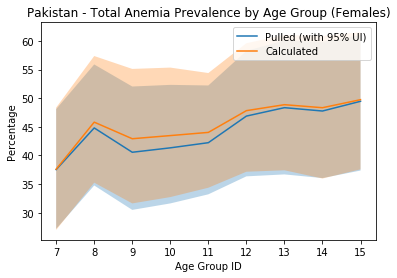

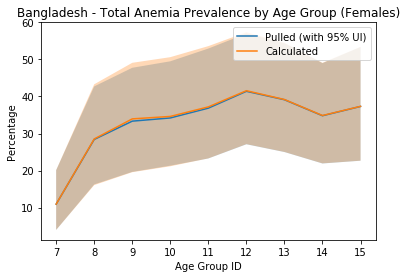

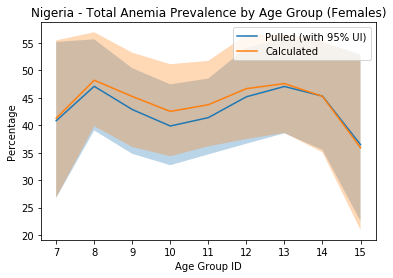

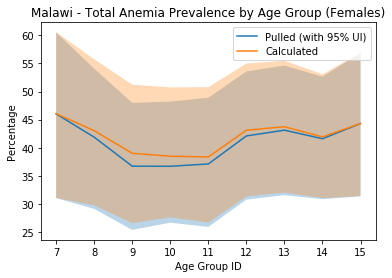

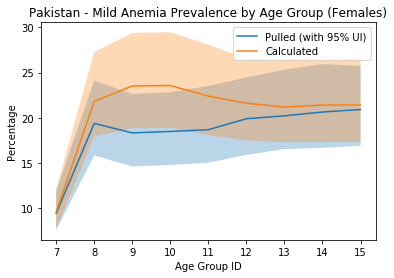

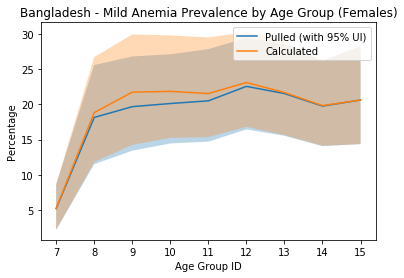

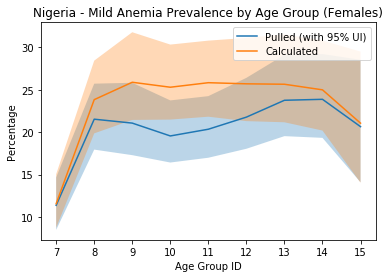

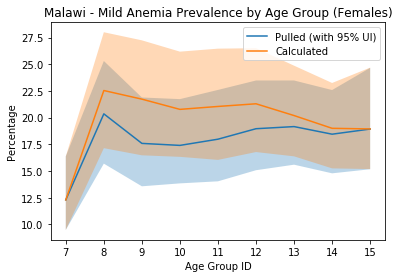

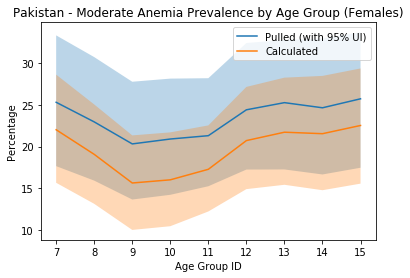

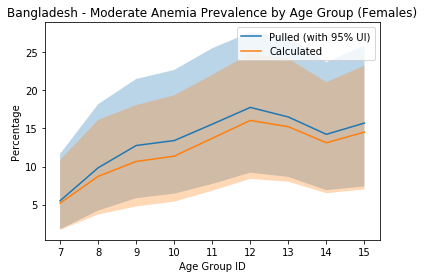

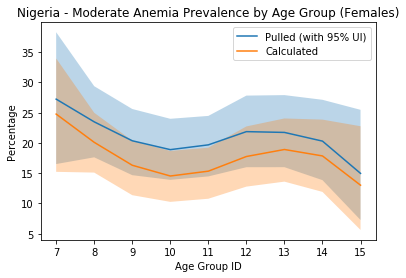

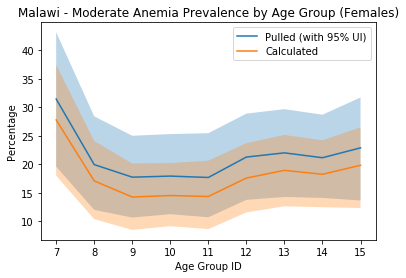

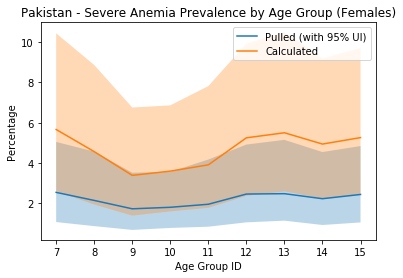

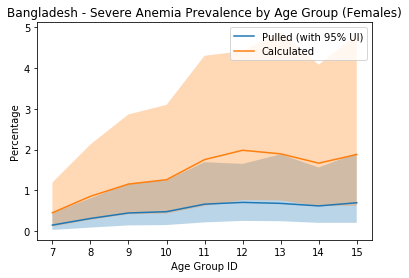

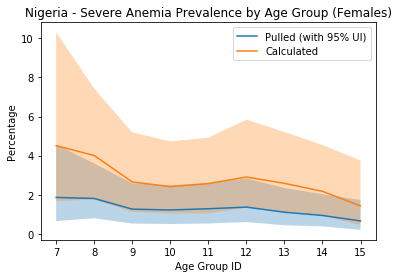

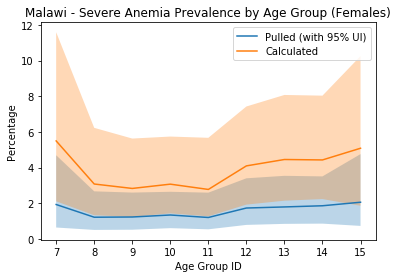

In [33]:
plot_calculated_vs_pulled(locs, ['total','mild','moderate','severe'])

# CONCLUSIONS:

The methodology in this notebook overestimates total and mild anemia prevalence and underestimates moderate and severe anemia prevalence relative to GBD 2019 anemia impairment prevalence, but **is generally within the GBD 95% uncertainty interval**, with a couple exceptions for mild anemia overestimation